# Analysis of: vddos
#### File originally retrieved from: https://t.co/gfK3VdR0zn 

<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FIRST PART: Pre-Analysis<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 1.1. Declaring the database dump file location 

In [1]:
dumpfile='attacks.txt'

## 1.2. Taking a look on the raw dump file (first 100 lines)

In [4]:
lines_to_read=100

with open(dumpfile) as myfile:
    firstlines=myfile.readlines()[0:lines_to_read] #put here the interval you want
    for x in firstlines:
        print(x.strip())




__  __  ____    _____   ____
/\ \/\ \/\  _`\ /\  __`\/\  _`\
\ \ \ \ \ \ \/\ \ \ \/\ \ \,\L\_\
\ \ \ \ \ \ \ \ \ \ \ \ \/_\__ \
\ \ \_/ \ \ \_\ \ \ \_\ \/\ \L\ \
\ `\___/\ \____/\ \_____\ `\____\
`\/__/  \/___/  \/_____/\/_____/


__  __              __
/\ \/\ \  __        /\ \__  __
\ \ \ \ \/\_\    ___\ \ ,_\/\_\    ___ ___     ____
\ \ \ \ \/\ \  /'___\ \ \/\/\ \ /' __` __`\  /',__\
\ \ \_/ \ \ \/\ \__/\ \ \_\ \ \/\ \/\ \/\ \/\__, `\
\ `\___/\ \_\ \____\\ \__\\ \_\ \_\ \_\ \_\/\____/
`\/__/  \/_/\/____/ \/__/ \/_/\/_/\/_/\/_/\/___/


These are all the DDOS victims that were logged in the VDOS database dump. The news on their site claims:


51,'DDoS','We\'re a legitimate stress testing company, not a DDoS service. you are prohibited from stressing internet connections and/or servers that you do not have ownership of or authorization to test.\r\n\r\nAbuse of our services or use in violation of our terms of service will result in being banned from our services.'

131,'prc','It is ne

<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
SECOND PART: Adapt to Our Generic Database Schema<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 2.0. Used Libraries

In [6]:
import pandas as pd
import numpy as np

from io import StringIO
import re

from IPython.display import display,clear_output

## 2.1. Listing tables that have content inserted into the dump file

In [7]:
def list_tables_with_insert(dumpfile):
    tables = []
    with open(dumpfile, 'rb') as f:
        for line in f:
            line = line.decode("utf-8").strip()
            if line.lower().startswith('insert'):
                table = re.findall(r'`(.*?)`', line)
                tables.append(table[0])
    return tables

In [8]:
tables=enumerate(list_tables_with_insert(dumpfile))

for i, item in tables:
    print(i+1,item)

1 logs
2 logs
3 logs
4 logs
5 logs
6 logs
7 logs
8 logs
9 logs
10 logs
11 logs
12 logs
13 logs
14 logs
15 logs
16 logs
17 logs
18 logs
19 logs
20 logs
21 logs
22 logs
23 logs
24 logs
25 logs
26 logs
27 logs
28 logs


## 2.2.A Read table function for well formed SQL dump

In [ ]:
# For well formed SQL database dumps!
def read_inserted_table(dumpfile, target_table):
    sio = StringIO()
    fast_forward = True
    with open(dumpfile, 'rb') as f:
        for line in f:
            line = line.decode("utf-8").strip()
            line = re.sub("(?!(([^']*'){2})*[^']*$)\)", '',line) #Step0:remove any ")" from the content of columns
            if line.lower().startswith('insert') and target_table in line:
                fast_forward = False
            if fast_forward:
                continue
            data = re.findall('\([^\)]*\)', line) #Step1: get the content between parentesis (i.e., insert line)
            try:
                newline = data[0].strip('()') #Step2:remove parenthesis
                newline=newline.replace('`','') #Step3: remove ` (usually in table names)
                newline=re.sub(r'(?!(([^\']*\'){2})*[^\']*$),', '', newline) #Step4: remove commas from the content of columns
                newline=newline.replace('\'','') #Step5: remove single quotes
                newline=newline.replace(', ', ',') #Step6: remove single spaces after comma (i.e., in the beginning of a column)
                sio.write(newline)
                sio.write("\n")
            except IndexError:
                pass
            if line.endswith(';'):
                break
    sio.seek(0)
    return sio

## 2.2.0. Converter functions for columns in tables

In [30]:
def tolowercase(text):
    try:
        return text.lower()
    except AttributeError:
        return text 

In [35]:
def strip_singlequote(text):
    try:
        return text.strip('\'')
    except AttributeError:
        return text

In [32]:
def timestamp2datetime(timestamp):
    try:
        return  pd.to_datetime(timestamp,unit='s')
    except AttributeError:
        return timestamp 

In [33]:
def dateformat2datetime(text):
    try:
        return  pd.to_datetime(text,format='%d-%m-%Y %H:%M')
    except AttributeError:
        return text 

## 2.2.0* Converter functions for VERY SPECIFIC COLUMNS

In [31]:
def strip_singlequote_and_tolowercase(text):
    try:
        return text.strip('\'').lower()
    except AttributeError:
        return text 

In [34]:
def strip_singlequote_and_dateformat2datetime(text):
    try:
        return  pd.to_datetime(text.strip('\''),format='%d-%m-%Y %H:%M')
    except AttributeError:
        return text 

In [36]:
def strip_parenthesisandsemicolon(text):
    try:
        return text.replace(');',"")
    except AttributeError:
        return text 

In [51]:
def strip_insertintologs(text):
    try:
        return int(text.replace('INSERT INTO `logs` VALUES (',""))
    except AttributeError:
        return text 

## 2.2.1.A Read the raw table: 'tablename'

In [ ]:
# tablename='<tablename>'

# pd.read_csv(read_inserted_table(dumpfile, tablename),
#             delimiter=",",
#             error_bad_lines=False).head(10)

## 2.2.1.B Read all lines (except the header lines)

In [48]:
num_header_lines=55

columns=['id', 'username', 'action', 'ip','date','platform','hidden']

df_manual= pd.read_csv(dumpfile,
            delimiter=",",
            skiprows = num_header_lines,
            names = columns)
df_manual.head(3)

,id,username,action,ip,date,platform,hidden
0,16166365,'John','Launched a stress test on 1.1.1.1:80 for 30 ...,'::1 ()','31-03-2016 20:59','Apple Safari v9.1 on mac',0
1,16166367,'John','Launched a stress test on 123.123.123.1:80 f...,'::1 ()','31-03-2016 21:02','Google Chrome v49.0.2623.110 on mac',0
2,16166370,'testing','Launched a stress test on 3.1.23.1:80 for 10...,'::1 ()','31-03-2016 21:19','Apple Safari v9.1 on mac',0


#### Manually analysing the first column

In [49]:
df_manual[df_manual['id'].str.contains('INSERT INTO')].head(3)

,id,username,action,ip,date,platform,hidden
5271,INSERT INTO `logs` VALUES (16311215,'xrenorg','Launched a stress test on 58.220.3.232:7777 ...,'27.150.217.42 (CN)','02-05-2016 23:49','Google Chrome v45.0.2454.101 on windows',0
12171,INSERT INTO `logs` VALUES (16324502,'vlo520','Launched a stress test on 61.160.222.53:80 f...,'113.95.20.90 (CN)','06-05-2016 03:09','Google Chrome v49.0.2623.112 on windows',0
19134,INSERT INTO `logs` VALUES (16337831,'yjx20072','Launched a stress test on 183.60.204.106:1588...,'183.51.242.150 (CN)','09-05-2016 06:52','Google Chrome v45.0.2454.101 on windows',0


#### Manually analysing the last column

In [50]:
df_manual[df_manual['hidden'].str.contains(';')].head(3)

,id,username,action,ip,date,platform,hidden
5270,16311214,'xrenorg','Launched a stress test on 222.186.135.85:7777...,'27.150.217.42 (CN)','02-05-2016 23:49','Google Chrome v45.0.2454.101 on windows',0);
12170,16324501,'jingwang','Launched a stress test on 59.44.20.101:80 fo...,'221.181.211.98 (CN)','06-05-2016 03:08','Google Chrome v47.0.2526.106 on windows',0);
15626,16331150,'RadeuXC','Launched a stress test on 83.36.233.54:80 fo...,'88.20.250.123 (ES)','07-05-2016 15:38','Mozilla Firefox v46.0 on windows',0);


#### Q1: Is this table different from other previous loaded table? YES
#### Q2: Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: attacks
    - The blacklist table must to have the columns: id, userid, username, targetip, targeturl, duration, port, and date
    
#### Q3: Are there modifications required? YES
    - On the table name: 
        o logs => attacks
    - On the column type: 
        o id => strip_insertintologs
        o username => strip_single_quote,
        o action => strip_single_quote,
        o ip => strip_single_quote,
        o date => strip_singlequote_and_dateformat2datetime,
        o platform => strip_single_quote,
        o hidden => strip_parenthesisandcomma    
    - On the column name:
        o ip => userip 
    - Add required columns:
        o userid
    - Split columns:
        o action => targetip, targeturl, port, duration

## 2.2.1.X.A Loading the modified table: 'tablename'

In [ ]:
# ### Loading the column converting columns with predefined functions
# df_<generictable> = pd.read_csv(read_inserted_table(dumpfile, tablename),
#                                 delimiter=",",
#                                 error_bad_lines=False,)
# #                        converters = {'date':timestamp2datetime})

# ###Changing names of columns
# df_<generictable>.rename(columns = {'actual1': 'generic_column_name1',
#                                     'actual2': 'generic_column_name2'},
#                          inplace=True)

# ###Creating empty columns (with "" [for future string] or np.nan [for future float])
# df_<generictable>['generic_column_name_missing'] = ""

# ###Showing some lines after adapt the table
# df_<generictable>.head(10)

## 2.2.1.X.B Loading the modified table: 'logs'

In [56]:
columns=['id', 'username', 'action', 'ip','date','platform','hidden']

df_attacks = pd.read_csv(dumpfile,\
                 skiprows=55,\
                 sep=",",\
                 names = columns,\
                 converters = {'id': strip_insertintologs,
                               'username' : strip_singlequote_and_tolowercase,
                               'action' : strip_singlequote,
                               'ip':strip_singlequote,
                               'date':strip_singlequote_and_dateformat2datetime,
                               'platform': strip_singlequote,
                               'hidden':strip_parenthesisandsemicolon})
df_attacks.head(5)

,id,username,action,ip,date,platform,hidden
0,16166365,john,Launched a stress test on 1.1.1.1:80 for 30 u...,::1 (),2016-03-31 20:59:00,Apple Safari v9.1 on mac,0
1,16166367,john,Launched a stress test on 123.123.123.1:80 fo...,::1 (),2016-03-31 21:02:00,Google Chrome v49.0.2623.110 on mac,0
2,16166370,testing,Launched a stress test on 3.1.23.1:80 for 100...,::1 (),2016-03-31 21:19:00,Apple Safari v9.1 on mac,0
3,16166372,john,Launched a stress test on 8.8.8.8:102 (DDoS pr...,79.176.82.202 (IL),2016-03-31 21:35:00,Apple Safari v9.1 on mac,0
4,16166375,john,Launched a stress test on 8.8.8.8:102 (DDoS pr...,79.176.82.202 (IL),2016-04-01 08:47:00,Apple Safari v9.1 on mac,0


#### Splitting the content of some columns in new columns

In [112]:
df_attacks['targetip']=df_attacks['action'].str.extract('on (?P<targetip>[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)', expand=True) 
df_attacks['targeturl']=df_attacks['action'].str.extract('on [A-Z]+://(?P<targeturl>[^\s:/]+)', expand=True, flags=re.IGNORECASE)
df_attacks['port']=df_attacks['action'].str.extract(':(?P<targetport>[0-9]+)', expand=True)
df_attacks['duration']=df_attacks['action'].str.extract('for\s+(?P<duration>[0-9]+)', expand=True)
df_attacks['type']=df_attacks['action'].str.extract('using\s+([a-z]\w{0,})', expand=True, flags=re.IGNORECASE)

df_attacks['userip']=df_attacks['ip'].str.extract('(([0-9a-fA-F]*[:\.])+[0-9a-fA-F]*)', expand=True)[0] #for  IPv4 and IPv6
df_attacks['country']=df_attacks['ip'].str.extract('([A-Z]\w)', expand=True,flags=re.IGNORECASE)

df_attacks['userid']=np.nan

#some extra info
df_attacks['vip_attack']=df_attacks['action'].str.contains('Launched a VIP stress test on', regex=True)
df_attacks['target_ddosprotected']=df_attacks['action'].str.contains('DDoS protected', regex=True)
df_attacks['user_os']=df_attacks['platform'].str.extract('on\s+(\w+)', expand=True,flags=re.IGNORECASE)
df_attacks['user_browser']=df_attacks['platform'].str.extract('\'(.*)\s+on', expand=True,flags=re.IGNORECASE)

#### Creating new tables with the information from the previous table

In [113]:
df_logins=df_attacks[['username','userip','date']]

#adding empty columns
df_logins['id']=np.nan
df_logins['userid']=np.nan

df_logins.head(3)

,username,userip,date,id,userid
0,john,::1,2016-03-31 20:59:00,NaN,NaN
1,john,::1,2016-03-31 21:02:00,NaN,NaN
2,testing,::1,2016-03-31 21:19:00,NaN,NaN


## 3.1. Adding missing tables accordingly to our generic Booter database 

In [70]:
df_users=pd.DataFrame(columns=['userid','username','useremail','password','expire','plan'])      
# df_logins=pd.DataFrame(columns=['id','userid','username','userip','date'])
# df_attacks= pd.DataFrame(columns=['id','userid','username','targetip','targeturl','duration','port','type','date'])
df_payments=pd.DataFrame(columns=['id','userid','username','amountpaid','paymentemail','planid','tid','date'])
df_settings=pd.DataFrame(columns=['url','sitename','siteemail'])
df_gateways=pd.DataFrame(columns=['email'])
df_friendsenemies=pd.DataFrame(columns=['id','ip','note','userid','type'])
df_blacklist=pd.DataFrame(columns=['id','ip','note'])
df_webshells=pd.DataFrame(columns=['id','url','status','lastchecked','attacktype'])
df_servers=pd.DataFrame(columns=['id','ip'])
df_plans=pd.DataFrame(columns=['planid','planname','plandescr','price','maxboottime','concurrency'])

<h1 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
THIRD PART: Data Enrichment<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h1> 

## 3.0. Needed Libraries

In [71]:
import subprocess

import cfscrape
from lxml import etree

import os.path

import random
import time 

## 3.1. Lookup functions

In [72]:
# THANKS TO: team-cymru.org
def iptoasn(iplist_teamcymruformat_filelocation,outputfile):
    cat = subprocess.Popen(['cat', iplist_teamcymruformat_filelocation], 
                            stdout=subprocess.PIPE)
    
    netcat = subprocess.Popen(['netcat', 'whois.cymru.com', '43'],
                              stdin=cat.stdout,
                              stdout=outputfile)
    time.sleep(3) #for some reason the poll does not work! This was the way to overcome the waiting time.
    
    return netcat.stdout      

In [73]:
# THANKS TO: exonerator.torproject.org
def WasTorNode(ip, date ):
    url="https://exonerator.torproject.org/?ip="+ip+"&timestamp="+date
    scraper = cfscrape.create_scraper()
    scraped_html=scraper.get(url).content    
    html_tree = etree.HTML(scraped_html)
    result=html_tree.xpath("//h3[@class='panel-title']/text()") # I was looking for <h3 class="panel-title">Result is positive</h3>
    tor_node=True if result == ['Result is positive'] else False
    return tor_node 
# 'date' MUST BE formated as: Year-month-day (2016-03-31)

## 3.2. Discovering the middle date of the database

In [74]:
try:
    try:
        middle_date=(min(df_attacks['date'])+((max(df_attacks['date'])-min(df_attacks['date']))/2))
        raise
    except Exception:
        pass

    try:
        middle_date=(min(df_logins['date'])+((max(df_logins['date'])-min(df_logins['date']))/2))
        raise
    except Exception:
        pass

    try:
        middle_date=(min(df_payments['date'])+((max(df_payments['date'])-min(df_payments['date']))/2))
        raise
    except:
        pass
except Exception:
    print("There is no date in the entire dataset")

date_tor_check = middle_date.strftime('%Y-%m-%d')
date_iptoasn_lookup= str(middle_date)
print(date_tor_check)

2016-05-27


## 3.3 Preparing to Perform IP to ASN info

In [75]:
df_logins['middledate']=date_iptoasn_lookup
df_attacks['middledate']=date_iptoasn_lookup
df_friendsenemies['middledate']=date_iptoasn_lookup
df_blacklist['middledate']=date_iptoasn_lookup

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## 3.4.1  Lookup IP to ASN info of table: logins

In [76]:
if (os.path.exists('logins_iptoasn_out')== False):
    logins_iptoasn_in = open('logins_iptoasn_in', 'w+')
    logins_iptoasn_in.write('begin\nverbose\n')
    df_logins[['userip','middledate']].drop_duplicates().to_csv(logins_iptoasn_in,header=False,index=False,sep="\t") 
    logins_iptoasn_in.write('end')
    logins_iptoasn_in.close()

    logins_iptoasn_out = open('logins_iptoasn_out', 'w+')
    iptoasn('logins_iptoasn_in',logins_iptoasn_out)
    logins_iptoasn_out.close()
else:
    print("You already performed the lookup for this table")

In [77]:
df_logins_iptoasn = pd.read_csv('logins_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_logins_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name
0,NaN,::1,NaN,NaN,other,NaN,2016-05-27 11:20:30,NaN
1,8551.0,79.176.82.202,79.176.80.0/20,IL,ripencc,2007-06-14,2016-05-27 11:20:30,BEZEQ-INTERNATIONAL-AS Bezeqint Internet Backb...
2,8551.0,79.180.106.225,79.180.96.0/20,IL,ripencc,2007-06-14,2016-05-27 11:20:30,BEZEQ-INTERNATIONAL-AS Bezeqint Internet Backb...
3,52026.0,109.207.46.21,109.207.46.0/24,RS,ripencc,2010-01-18,2016-05-27 11:20:30,"TRUF-AS , RS"
4,8445.0,89.26.122.67,89.26.0.0/17,AT,ripencc,2006-06-12,2016-05-27 11:20:30,"SALZBURG-AG-AS , AT"
5,8551.0,109.66.26.251,109.66.16.0/20,IL,ripencc,2009-08-10,2016-05-27 11:20:30,BEZEQ-INTERNATIONAL-AS Bezeqint Internet Backb...
6,23724.0,101.254.187.92,101.254.184.0/22,CN,apnic,2011-01-24,2016-05-27 11:20:30,"CHINANET-IDC-BJ-AP IDC, China Telecommunicatio..."
7,4847.0,117.114.129.36,117.114.128.0/20,CN,apnic,2007-07-25,2016-05-27 11:20:30,"CNIX-AP China Networks Inter-Exchange, CN"
8,58542.0,42.81.69.214,42.81.0.0/16,CN,apnic,2011-02-21,2016-05-27 11:20:30,"CHINATELECOM-HUNAN-YUEYANG-MAN Yueyang, CN"
9,25820.0,45.78.11.40,45.78.0.0/19,CA,arin,2015-05-05,2016-05-27 11:20:30,"IT7NET - IT7 Networks Inc, CA"


## 3.4.2  Lookup IP to ASN info of table: attacks

In [78]:
if (os.path.exists('attacks_iptoasn_out')== False):
    attacks_iptoasn_in = open('attacks_iptoasn_in', 'w+')
    attacks_iptoasn_in.write('begin\nverbose\n')
    df_attacks[['targetip','middledate']].drop_duplicates().to_csv(attacks_iptoasn_in,header=False,index=False,sep="\t") 
    attacks_iptoasn_in.write('end')
    attacks_iptoasn_in.close()

    attacks_iptoasn_out = open('attacks_iptoasn_out', 'w+')
    iptoasn('attacks_iptoasn_in',attacks_iptoasn_out)
    attacks_iptoasn_out.close()
else:
    print("You already performed the lookup for this table")

In [79]:
df_attacks_iptoasn = pd.read_csv('attacks_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_attacks_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name
0,NaN,1.1.1.1,NaN,AU,apnic,2011-08-11,2016-05-27 11:20:30,NaN
1,4808,123.123.123.1,123.123.64.0/18,CN,apnic,2007-01-29,2016-05-27 11:20:30,CHINA169-BJ China Unicom Beijing Province Netw...
2,NaN,3.1.23.1,NaN,US,arin,NaN,2016-05-27 11:20:30,NaN
3,15169,8.8.8.8,8.8.8.0/24,US,arin,NaN,2016-05-27 11:20:30,"GOOGLE - Google Inc., US"
4,16276,37.59.48.31,37.59.0.0/16,FR,ripencc,2012-01-16,2016-05-27 11:20:30,"OVH , FR"
5,44066,31.172.80.104,31.172.64.0/19,DE,ripencc,2011-04-01,2016-05-27 11:20:30,"DE-FIRSTCOLO www.first-colo.net, DE"
6,20940,104.85.165.1,104.85.165.0/24,US,arin,2014-04-22,2016-05-27 11:20:30,"AKAMAI-ASN1 , US"
7,3734,204.88.138.97,204.88.128.0/19,US,arin,NaN,2016-05-27 11:20:30,"SCCO - Santa Clara County Office of Education, US"
8,58543,183.2.247.168,183.2.244.0/22,CN,apnic,2009-10-09,2016-05-27 11:20:30,"CHINATELECOM-GUANGDONG-IDC Guangdong, CN"
9,59037,43.227.194.239,43.227.194.0/23,CN,apnic,2014-12-22,2016-05-27 11:20:30,ZHIYUNET Hangzhou ZhiYu Network Technology Co....


## 3.4.3  Lookup IP to ASN info of table: friendsenemies

In [80]:
if (os.path.exists('friendsenemies_iptoasn_out')== False):
    friendsenemies_iptoasn_in = open('friendsenemies_iptoasn_in', 'w+')
    friendsenemies_iptoasn_in.write('begin\nverbose\n')
    df_friendsenemies[['ip','middledate']].drop_duplicates().to_csv(friendsenemies_iptoasn_in,header=False,index=False,sep="\t") 
    friendsenemies_iptoasn_in.write('end')
    friendsenemies_iptoasn_in.close()

    friendsenemies_iptoasn_out = open('friendsenemies_iptoasn_out', 'w+')
    iptoasn('friendsenemies_iptoasn_in',friendsenemies_iptoasn_out)
    friendsenemies_iptoasn_out.close()
else:
    print("You already performed the lookup for this table.")

In [82]:
df_friendsenemies_iptoasn = pd.read_csv('friendsenemies_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_friendsenemies_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name


## 3.4.4  Lookup IP to ASN info of table: blacklist

In [83]:
if (os.path.exists('blacklist_iptoasn_out')== False):
    blacklist_iptoasn_in = open('blacklist_iptoasn_in', 'w+')
    blacklist_iptoasn_in.write('begin\nverbose\n')
    df_blacklist[['ip','middledate']].drop_duplicates().to_csv(blacklist_iptoasn_in,header=False,index=False,sep="\t") 
    blacklist_iptoasn_in.write('end')
    blacklist_iptoasn_in.close()

    blacklist_iptoasn_out = open('blacklist_iptoasn_out', 'w+')
    iptoasn('blacklist_iptoasn_in',blacklist_iptoasn_out)
    blacklist_iptoasn_out.close()
else:
    print("You already performed the lookup for this table.")

In [84]:
df_blacklist_iptoasn = pd.read_csv('blacklist_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_blacklist_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name


# 3.5.1. Check if IP was a TOR node for table: login

In [85]:
date_tor_check

'2016-05-27'

In [ ]:
if len(df_logins['userip'].unique())<1200:
    if (os.path.exists('logins_torcheck')== False):
        print("Note: it can take a while to finish...")
        logins_torcheck = open('logins_torcheck', 'w+')
        for i in df_logins['userip'].unique():
            wasTor=WasTorNode(i,date_tor_check)
            print(i, wasTor, file=logins_torcheck)
    #         print(i, wasTor) #DEBUGING =D
            time.sleep(random.randint(1,3)) #adding some random sleep time
            logins_torcheck.flush()

        logins_torcheck.close()
    else:
        print("The IP addresses from this table were already checked.")
else:
        print("Aborted!!! It will take more than one hour to analyse!")

In [ ]:
df_logins_torcheck = pd.read_csv('logins_torcheck',\
                          delimiter="\s+",\
                          names = ['userip', 'tor'])

# 3.5.2. Check if IP was a TOR node for table: attacks

In [93]:
if len(df_attacks['targetip'].unique())<1200:
    if (os.path.exists('attacks_torcheck')== False):
        print("Note: it can take a while to finish...",len(df_attacks['targetip'].unique())*3,"seconds (in the worst case).")

        attacks_torcheck = open('attacks_torcheck', 'w+')

        for i in df_attacks['targetip'].unique():
            wasTor=WasTorNode(i,date_tor_check)
            print(i, wasTor, file=attacks_torcheck)
            print(i, wasTor) #DEBUGING =D
            time.sleep(random.randint(1,3)) #adding some random sleep time
            attacks_torcheck.flush()

        attacks_torcheck.close()
    else:
        print("The IP addresses from this table were already checked.") 
else:
        print("Aborted!!! It will take more than one hour to analyse!")

The IP addresses from this table were already checked.


In [ ]:
df_attacks_torcheck = pd.read_csv('attacks_torcheck',\
                          delimiter="\s+",\
                          names = ['targetip', 'tor'])

# 3.5.3. Check if IP was a TOR node for table: friendsenemies

In [89]:
if len(df_friendsenemies['ip'].unique()) <1200:
    if (os.path.exists('friendsenemies_torcheck')== False):
        print("Note: it can take a while to finish...",len(df_friendsenemies['ip'].unique())*3,"seconds (in the worst case).")

        friendsenemies_torcheck = open('friendsenemies_torcheck', 'w+')

        for i in df_friendsenemies['ip'].unique():
            wasTor=WasTorNode(i,date_tor_check)
            print(i, wasTor, file=friendsenemies_torcheck)
        #     print(i, wasTor) #DEBUGING =D
            time.sleep(random.randint(1,3)) #adding some random sleep time
            friendsenemies_torcheck.flush()

        friendsenemies_torcheck.close()
    else:
        print("The IP addresses from this table were already checked.") 
else:
        print("Aborted!!! It will take more than one hour to analyse!")

Note: it can take a while to finish... 0 seconds (in the worst case).


In [90]:
df_friendsenemies_torcheck = pd.read_csv('friendsenemies_torcheck',\
                          delimiter="\s+",\
                          names = ['ip', 'tor'])

# 3.5.4. Check if IP was a TOR node for table: blacklist

In [160]:
if len(df_blacklist['ip'].unique()) < 1200:
    if (os.path.exists('blacklist_torcheck')== False):
        print("Note: it can take a while to finish...",len(df_blacklist['ip'].unique())*3,"seconds (in the worst case).")

        blacklist_torcheck = open('blacklist_torcheck', 'w+')

        for i in df_blacklist['ip'].unique():
            wasTor=WasTorNode(i,date_tor_check)
            print(i, wasTor, file=blacklist_torcheck)
    #         print(i, wasTor) #DEBUGING =D
            time.sleep(random.randint(1,3)) #adding some random sleep time
            blacklist_torcheck.flush()

        blacklist_torcheck.close()
    else:
        print("The IP addresses from this table were already checked.") 
else:
        print("Aborted!!! It will take more than one hour to analyse!")

The IP addresses from this table were already checked.


In [92]:
df_blacklist_torcheck = pd.read_csv('blacklist_torcheck',\
                          delimiter="\s+",\
                          names = ['ip', 'tor'])

<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FOURTH PART: Automatic Analysis
<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 5.0. Used Libraries

In [94]:
import matplotlib.pyplot as plt
from matplotlib_venn import *
%matplotlib inline

plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

## 5.1. Number of users, customers, attackers, and their intersection

In [98]:
df_attacks.head(1)

,id,username,action,ip,date,platform,hidden,targetip,targeturl,port,duration,type,userip,country,vip_attack,target_ddosprotected,user_os,user_browser,middledate
0,16166365,john,Launched a stress test on 1.1.1.1:80 for 30 u...,::1 (),2016-03-31 20:59:00,Apple Safari v9.1 on mac,0,1.1.1.1,NaN,80,30,ESSYN,::1,NaN,False,False,mac,NaN,2016-05-27 11:20:30


In [106]:
len(df_users['username'].unique())

0

In [116]:
set(df_attacks['userid'].unique())

{nan}

In [117]:
if len(set(df_users['userid'].unique())) > 1:
    users_set=set(df_users['userid'].unique())
else:
    users_set=set(df_users['username'].unique())

if len(set(df_payments['userid'].unique())) > 1:
    customers_set=set(df_payments['userid'].unique())
else:
    customers_set=set(df_payments['username'].unique())

if len(set(df_attacks['userid'].unique())) > 1:
    attackers_set=set(df_attacks['userid'].unique())
else:
    attackers_set=set(df_attacks['username'].unique())

intersec_customers_attacker=pd.Series(list(customers_set.intersection(attackers_set)))
intersec_users_customers=pd.Series(list(users_set.intersection(customers_set)))
intersec_users_attackers=pd.Series(list(users_set.intersection(attackers_set)))

intersec_users_customers_attackers=pd.Series(list(users_set.intersection(customers_set).intersection(attackers_set)))

*Users set is empty!
*Customers set is empty!


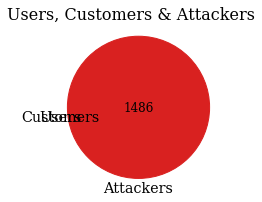

In [118]:
fig = plt.figure(figsize=(4,3))
fig.suptitle('Users, Customers & Attackers', fontsize=16)

ax = plt.subplot2grid((1,1), (0,0))

venn=venn3(ax=ax,subsets = {'001':len(attackers_set)-len(intersec_customers_attacker)-len(intersec_users_attackers)+len(intersec_users_customers_attackers), 
                            '010':len(customers_set)-len(intersec_users_customers)-len(intersec_customers_attacker)+len(intersec_users_customers_attackers), 
                            '011':len(intersec_customers_attacker)-len(intersec_users_customers_attackers),
                            '100':len(users_set)-len(intersec_users_customers)-len(intersec_users_attackers)+len(intersec_users_customers_attackers),
                            '101':len(intersec_users_attackers)-len(intersec_users_customers_attackers),
                            '110':len(intersec_users_customers)-len(intersec_users_customers_attackers),
                            '111':len(intersec_users_customers_attackers)},\
          set_labels = ('Users', 'Customers','Attackers'),\
          alpha=1)
try:
    venn.get_patch_by_id('100').set_color('#404096')
except:
    print("*Users set is empty!")  
    
try:
    venn.get_patch_by_id('110').set_color('#DEA73A')
except:
    print("*Customers set is empty!")   

try:
    venn.get_patch_by_id('001').set_color('#D92120')
except:
    print("*Attackers set is empty!")

fig.show()
# fig.savefig('../figs/timeseries_attacks.eps', format='eps', dpi=1200) 

## 5.2. Distribution of login times per user

In [127]:
len(df_logins['userid'].value_counts())

0

In [131]:
if len(df_logins['userid'].value_counts()) > 0:
    num_distinct_logins_per_user=df_logins['userid'].value_counts()
else:
    num_distinct_logins_per_user=df_logins['username'].value_counts()

freq_distinct_logins_per_user=num_distinct_logins_per_user.value_counts()
cum_dist_user_logins = np.linspace(0.,1.,len(num_distinct_logins_per_user))
cdf_user_logins = pd.Series(cum_dist_user_logins, index=num_distinct_logins_per_user.sort_values())

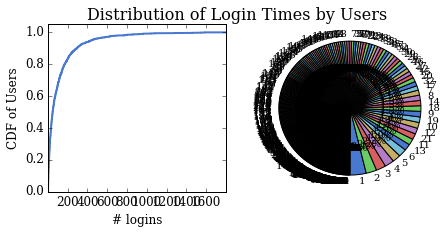

In [132]:
if len(num_distinct_logins_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Login Times by Users', fontsize=16)

    #Plot CDF
    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_logins.plot(ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# logins")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_logins_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.3. Distribution of IP addresses per user

In [138]:
if len(df_logins.groupby(['userid','userip']).size().reset_index()['userid'].value_counts()) >0:
    num_distinct_ips_per_user=df_logins.groupby(['userid','userip']).size().reset_index()['userid'].value_counts()
else:
    num_distinct_ips_per_user=df_logins.groupby(['username','userip']).size().reset_index()['username'].value_counts()
    
freq_distinct_ips_per_user=num_distinct_ips_per_user.value_counts()
cum_dist_user_ips = np.linspace(0.,1.,len(num_distinct_ips_per_user))
cdf_user_ips = pd.Series(cum_dist_user_ips, index=num_distinct_ips_per_user.sort_values())

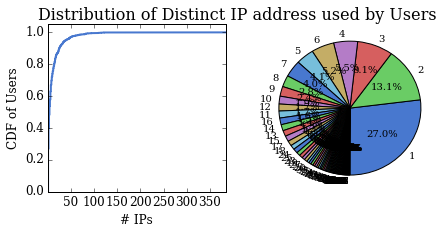

In [139]:
if len(num_distinct_ips_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Distinct IP address used by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_ips.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# IPs")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_ips_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.4. Distribution of Number of Payments by Users

In [140]:
if len(df_payments['userid'].value_counts())>0:
    num_distinct_payments_per_user=df_payments['userid'].value_counts()
else:
    num_distinct_payments_per_user=df_payments['username'].value_counts()

freq_distinct_payments_per_user=num_distinct_payments_per_user.value_counts()
cum_dist_user_payments = np.linspace(0.,1.,len(num_distinct_payments_per_user))
cdf_user_payments = pd.Series(cum_dist_user_payments, index=num_distinct_payments_per_user.sort_values())

In [141]:
if len(num_distinct_payments_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Number of Payments by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_payments.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# Payment")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_payments_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

Unfortunately, there is no data available!


## 5.5. Total amount of money earned

In [144]:
if len(df_payments['amountpaid']) >0:
    total_earned=df_payments['amountpaid'].values.sum()
    'US$ {:,.2f}'.format(float(total_earned))
else:
    print("Unfortunately, there is no data available!")

Unfortunately, there is no data available!


## 5.6. Distribution of the money paid by Users

In [145]:
num_distinct_payments_money_per_user=df_payments['amountpaid'].value_counts()
freq_distinct_payments_money_per_user=num_distinct_payments_money_per_user.value_counts()
cum_dist_user_payments_money = np.linspace(0.,1.,len(num_distinct_payments_money_per_user))
cdf_user_payments_money = pd.Series(cum_dist_user_payments_money, index=num_distinct_payments_money_per_user.sort_values())

In [146]:
if len(num_distinct_payments_money_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Money Payments by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_payments_money.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("US$")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_payments_money_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

Unfortunately, there is no data available!


## 5.7. Distribution of Countries that users access Booters

In [147]:
logins_country_distribution=df_logins_iptoasn['country'].value_counts()

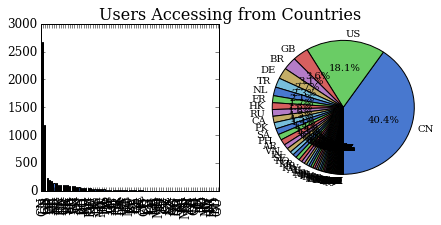

In [148]:
if len(logins_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Users Accessing from Countries', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    logins_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    logins_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

## 5.8. Countries of blacklisted IPs

In [149]:
blacklist_country_distribution=df_blacklist_iptoasn['country'].value_counts()

In [150]:
if len(blacklist_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Countries of blacklisted IPs', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    blacklist_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    blacklist_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

Unfortunately, there is no data available!


## 5.9. Countries of target IPs

In [151]:
attacks_country_distribution=df_attacks_iptoasn['country'].value_counts()

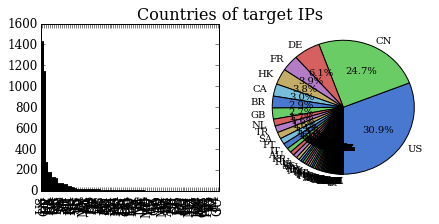

In [152]:
if len(attacks_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Countries of target IPs', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    attacks_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    attacks_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

<h2 align="center">!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FIFTH PART: Query Interface<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h2> 

In [153]:
from ipywidgets import widgets, interact
from IPython.display import display,clear_output

##  5.1. Search user by name or email

In [154]:
def searchfor_username_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_username.value,"\" in df_users:")
    display(df_users[df_users['username']== searchfor_username.value.lower()])

def searchfor_useremail_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_useremail.value,"\" in df_users:")
    display(df_users[df_users['useremail']== searchfor_useremail.value])
    print("Searching for \"",searchfor_useremail.value,"\" in df_payment:")
    display(df_payments[df_payments['paymentemail']== searchfor_useremail.value])

In [155]:
searchfor_username = widgets.Text(description="username")
display(searchfor_username)
searchfor_username.on_submit(searchfor_username_submit)

searchfor_useremail = widgets.Text(description="email")
display(searchfor_useremail)
searchfor_useremail.on_submit(searchfor_useremail_submit)

## 5.2. Search attacks by username or userid

In [156]:
def searchfor_attacks_userid_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_attacks_userid.value,"\" in df_attacks:")
    display(df_attacks[df_attacks['userid']== searchfor_attacks_userid.value])

def searchfor_attacks_username_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_attacks_username.value,"\" in df_attacks:")
    userid=df_users[df_users['username']==searchfor_attacks_username.value.lower()]['userid'].iloc[0]
    display(df_attacks[df_attacks['userid']== userid])

In [157]:
searchfor_attacks_username = widgets.Text(description="username",)
display(searchfor_attacks_username)
searchfor_attacks_username.on_submit(searchfor_attacks_username_submit)

searchfor_attacks_userid = widgets.Text(description="userid")
display(searchfor_attacks_userid)
searchfor_attacks_userid.on_submit(searchfor_attacks_userid_submit)

## 5.3. Search IP address by userid or username

In [158]:
def search_ips_by_userid_submit(sender):
    clear_output()
    print("Searching for \"",search_ips_by_userid.value,"\" in df_logins:")
    display(df_logins[df_logins['userid']== int(search_ips_by_userid.value)])

def search_ips_by_username_submit(sender):
    clear_output()
    print("Searching for \"",search_ips_by_username.value,"\" in df_logins:")
    userid=df_users[df_users['username']==search_ips_by_username.value.lower()]['userid'].iloc[0]
    display(df_logins[df_logins['userid']== userid])

In [159]:
search_ips_by_username = widgets.Text(description="username")
display(search_ips_by_username)
search_ips_by_username.on_submit(search_ips_by_username_submit)

search_ips_by_userid = widgets.Text(description="userid")
display(search_ips_by_userid)
search_ips_by_userid.on_submit(search_ips_by_userid_submit)